In [1]:
import pandas as pd
import numpy as np
import torch
import time
from datetime import datetime
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from scipy.stats import norm

# CIFAR-10 constituent samples' extraction
This notebook shows how to construct a dataset that has only CIFAR samples. This can be used for other tasks or for assessment of models trained on the imagenet constituents, to understand how well these models deal with distribution shift. 

#### ENSURE THAT CINIC-10 IS DOWNLOADED AND STORED IN ../data/cinic-10

In [149]:
br_file = '../cifar10-vs-ti/benrecht_cifar10.csv'
cifar_file = '../cifar10-vs-ti/cifar10_test.csv'
cinic_file = '../cifar10-vs-ti/cinic10_test.csv'
ti_file = '../cifar10-vs-ti/tinyimages.csv'
cifar_train_file = '../cifar10-vs-ti/cifar10_train.csv'
cinic_train_file = '../cifar10-vs-ti/cinic10_train.csv'

br_df = pd.read_csv(br_file)
cifar_df = pd.read_csv(cifar_file)
cinic_df = pd.read_csv(cinic_file)
cifar_train_df = pd.read_csv(cifar_train_file)
cinic_train_df = pd.read_csv(cinic_train_file)
ti_df = pd.read_csv(ti_file)

In [150]:
print(br_df.shape)
print(cifar_df.shape)
print(cinic_df.shape)
print(cifar_train_df.shape)
print(cinic_train_df.shape)
print(ti_df.shape)

(2021, 28)
(10000, 28)
(70000, 28)
(50000, 28)
(70000, 28)
(50000, 28)


In [132]:
ti_df[0:5].iloc[:,0:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,15315.0,0.0,0.000220,0.000211,0.000197,0.000225,0.000130,0.000250,0.000172,0.000123,0.000252,0.000345,0.997875,0.004904,0.000222
1,9114.0,0.0,0.000155,0.000345,0.000100,0.000227,0.000155,0.000198,0.000107,0.000221,0.000191,0.000351,0.997950,0.782901,0.001761
2,11485.0,0.0,0.000088,0.000160,0.000043,0.000101,0.000028,0.000040,0.000047,0.000017,0.000022,0.000042,0.999411,0.762853,0.046946
3,45427.0,0.0,0.000144,0.000244,0.000186,0.000104,0.001363,0.000279,0.000143,0.000348,0.000160,0.000183,0.996845,0.140101,0.000648
4,47502.0,0.0,0.000099,0.000153,0.000089,0.000074,0.000080,0.000097,0.000085,0.000123,0.000167,0.000169,0.998864,0.002683,0.001032


In [151]:
br_det_scores = br_df.iloc[:,2:13]
cifar_det_scores = cifar_df.iloc[:,2:13]
cinic_det_scores = cinic_df.iloc[:,2:13]
ti_det_scores = ti_df.iloc[:,2:13]
cifar_train_det_scores = cifar_train_df.iloc[:,2:13]
cinic_train_det_scores = cinic_train_df.iloc[:,2:13]


br_base_scores = br_df.iloc[:,13:23]
cifar_base_scores = cifar_df.iloc[:,13:23]
cinic_base_scores = cinic_df.iloc[:,13:23]
ti_base_scores = ti_df.iloc[:,13:23]
cifar_train_base_scores = cifar_train_df.iloc[:,13:23]
cinic_train_base_scores = cinic_train_df.iloc[:,13:23]

br_targets = br_df.iloc[:,1]
cifar_targets = cifar_df.iloc[:,1]
cinic_targets = cinic_df.iloc[:,1]
ti_targets = ti_df.iloc[:,1]
cifar_train_targets = cifar_train_df.iloc[:,1]
cinic_train_targets = cinic_train_df.iloc[:,1]

br_preds = br_df.iloc[:,23]
cifar_preds = cifar_df.iloc[:,23]
cinic_preds = cinic_df.iloc[:,23]
ti_preds = ti_df.iloc[:,23]
cifar_train_preds = cifar_train_df.iloc[:,23]
cinic_train_preds = cinic_train_df.iloc[:,23]

br_base_preds = br_df.iloc[:,24]
cifar_base_preds = cifar_df.iloc[:,24]
cinic_base_preds = cinic_df.iloc[:,24]
ti_base_preds = ti_df.iloc[:,24]
cifar_train_base_preds = cifar_train_df.iloc[:,24]
cinic_train_base_preds = cinic_train_df.iloc[:,24]


In [152]:
# br_det_scores[0:5]
print(ti_det_scores[0:5])
print(ti_base_scores[0:5])
print(ti_targets[0:5])
print(ti_preds[0:5])
print(ti_base_preds[0:5])

          2         3         4         5         6         7         8  \
0  0.000220  0.000211  0.000197  0.000225  0.000130  0.000250  0.000172   
1  0.000155  0.000345  0.000100  0.000227  0.000155  0.000198  0.000107   
2  0.000088  0.000160  0.000043  0.000101  0.000028  0.000040  0.000047   
3  0.000144  0.000244  0.000186  0.000104  0.001363  0.000279  0.000143   
4  0.000099  0.000153  0.000089  0.000074  0.000080  0.000097  0.000085   

          9        10        11        12  
0  0.000123  0.000252  0.000345  0.997875  
1  0.000221  0.000191  0.000351  0.997950  
2  0.000017  0.000022  0.000042  0.999411  
3  0.000348  0.000160  0.000183  0.996845  
4  0.000123  0.000167  0.000169  0.998864  
         13        14        15        16        17        18        19  \
0  0.004904  0.000222  0.050344  0.117854  0.043294  0.763045  0.001195   
1  0.782901  0.001761  0.029430  0.021935  0.001235  0.000380  0.012634   
2  0.762853  0.046946  0.000054  0.007641  0.022469  0.00724

In [135]:
# (pd.to_numeric(cifar_det_scores.iloc[:,0:10].idxmax(axis=1)) - 2 == cifar_targets).sum()
# (cifar_preds == cifar_targets).sum()
((pd.to_numeric(cifar_det_scores.iloc[:,0:10].idxmax(axis=1)) - 2) == cifar_targets).sum()
# pd.to_numeric(cifar_det_scores[cifar_preds == 10].iloc[:,0:10].idxmax(axis=1)) -  2
# ((pd.to_numeric(cifar_det_scores[cifar_preds == 10].iloc[:,0:10].idxmax(axis=1)) - 2) == cifar_targets[cifar_preds == 10]).sum()

# ((pd.to_numeric(cifar_det_scores[cifar_preds != 10].iloc[:,0:10].idxmax(axis=1)) - 2) == cifar_targets[cifar_preds != 10]).sum()

# (cifar_preds == 10).sum()

# (cifar_base_preds[cifar_preds != 10] == cifar_targets[cifar_preds != 10]).sum()
# len(cifar_targets)

9613

In [153]:
def verify(df, df_det_scores, df_base_scores, df_targets, df_preds, df_base_preds):
    cifar10_correct = ((pd.to_numeric(df_det_scores.iloc[:,0:10].idxmax(axis=1)) - 2) == df_targets).sum()
    total = len(df_targets)
    
    predti_pseudo_corr = ((pd.to_numeric(df_det_scores[df_preds == 10].iloc[:,0:10].idxmax(axis=1)) - 2) == df_targets[df_preds == 10]).sum()
    predcifar_corr = ((pd.to_numeric(df_det_scores[df_preds != 10].iloc[:,0:10].idxmax(axis=1)) - 2) == df_targets[df_preds != 10]).sum()
    
    predti_count = (df_preds == 10).sum()
    predcifar_count = (df_preds != 10).sum()
    
    base_cifar_correct = (df_base_preds == df_targets).sum()
    base_predcifar_correct = (df_base_preds[df_preds != 10] == df_targets[df_preds != 10]).sum()
    base_predti_correct = (df_base_preds[df_preds == 10] == df_targets[df_preds == 10]).sum()
    
    print("Total %d cifar10 correct %d" %(total, cifar10_correct))
    print("Predicted c10 count %d predicted c10 correct %d, predicted ti count %d pred ti pseudo correct %d" \
              %(predcifar_count, predcifar_corr, predti_count, predti_pseudo_corr))
    print("base cifar10 correct %d, base pred c10 corect  %d, base predicted ti correct %d" \
                  %(base_cifar_correct, base_predcifar_correct, base_predti_correct))
    
    print('------------------------------------------------------------------------')
    

In [154]:
verify(cifar_df, cifar_det_scores, cifar_base_scores, cifar_targets, cifar_preds, cifar_base_preds)
verify(br_df, br_det_scores, br_base_scores, br_targets, br_preds, br_base_preds)
verify(cinic_df, cinic_det_scores, cinic_base_scores, cinic_targets, cinic_preds, cinic_base_preds)
verify(ti_df, ti_det_scores, ti_base_scores, ti_targets, ti_preds, ti_base_preds)

verify(cifar_train_df, cifar_train_det_scores, cifar_train_base_scores, cifar_train_targets, cifar_train_preds, cifar_train_base_preds)
verify(cinic_train_df, cinic_train_det_scores, cinic_train_base_scores, cinic_train_targets, cinic_train_preds, cinic_train_base_preds)

Total 10000 cifar10 correct 9613
Predicted c10 count 9154 predicted c10 correct 8998, predicted ti count 846 pred ti pseudo correct 615
base cifar10 correct 9208, base pred c10 corect  8684, base predicted ti correct 524
------------------------------------------------------------------------
Total 2021 cifar10 correct 1828
Predicted c10 count 1583 predicted c10 correct 1527, predicted ti count 438 pred ti pseudo correct 301
base cifar10 correct 1682, base pred c10 corect  1429, base predicted ti correct 253
------------------------------------------------------------------------
Total 70000 cifar10 correct 49719
Predicted c10 count 42331 predicted c10 correct 37084, predicted ti count 27669 pred ti pseudo correct 12635
base cifar10 correct 45902, base pred c10 corect  34699, base predicted ti correct 11203
------------------------------------------------------------------------
Total 50000 cifar10 correct 3472
Predicted c10 count 1644 predicted c10 correct 368, predicted ti count 4835

In [126]:
df, df_det_scores, df_base_scores, df_targets, df_preds, df_base_preds = (cifar_df, cifar_det_scores, cifar_base_scores, cifar_targets, cifar_preds, cifar_base_preds)

In [140]:
br_det_scores[br_preds==10].iloc[:,-1]

10      0.998449
12      0.999129
15      0.632341
23      0.999399
25      0.790526
          ...   
2005    0.999652
2008    0.998796
2011    0.985885
2016    0.615684
2017    0.999631
Name: 12, Length: 438, dtype: float64

In [144]:
def plot_df_hist(df):
    mu, std = norm.fit(df)
    plt.figure()
    plt.hist(df, bins = 100, histtype = 'bar')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Softmax confidence Fit results: mu = %.2f,  std = %.2f, count = %d" % (mu, std, len(df))
    plt.title(title)
    plt.xlabel("Max confidence of softmax outputs")
    plt.ylabel('Count')
    # plt.title('Histogram of cross entropy loss for unlabeled data')
    plt.show()

In [186]:
def plot_det_11thclass_conf_on_hard_part_hist(df_det_scores, df_preds):
    assert len(df_det_scores) == len(df_preds), 'length of dfs unequal'
    plot_df_hist(df_det_scores[df_preds==10].iloc[:,-1])

def plot_det_top_conf_on_hard_part_hist(df_det_scores, df_preds):
    assert len(df_det_scores) == len(df_preds), 'length of dfs unequal'
    df_hard_part_scores = df_det_scores[df_preds==10].iloc[:,0:10]
    plot_df_hist(df_hard_part_scores.max(axis=1))

def plot_base_top_conf_on_hard_part_hist(df_base_scores, df_preds):
    assert len(df_base_scores) == len(df_preds), 'length of dfs unequal'
    df_hard_part_scores = df_base_scores[df_preds==10]
    plot_df_hist(df_hard_part_scores.max(axis=1))

In [180]:
df_det_scores[df_preds==10][0:10]

,2,3,4,5,6,7,8,9,10,11,12
2,0.004209,0.038084,0.000483,0.000630,0.000437,0.000778,0.000404,0.000336,0.434786,0.000736,0.519117
6,0.000397,0.338432,0.000248,0.000218,0.000229,0.000669,0.000279,0.000874,0.000269,0.001839,0.656545
22,0.000577,0.000170,0.000478,0.000226,0.272263,0.000178,0.000280,0.000152,0.000222,0.000181,0.725272
26,0.000380,0.000254,0.000397,0.000192,0.273538,0.000440,0.000560,0.000521,0.000299,0.000332,0.723088
37,0.000732,0.026154,0.000314,0.000381,0.000577,0.000631,0.000522,0.000593,0.000762,0.114180,0.855153
47,0.000107,0.000131,0.000050,0.000035,0.000051,0.000038,0.000112,0.000035,0.000111,0.000310,0.999019
59,0.001811,0.002756,0.000560,0.100214,0.001857,0.003092,0.131193,0.001213,0.000841,0.001175,0.755287
81,0.001334,0.014478,0.000432,0.000679,0.000746,0.000716,0.000698,0.000456,0.000857,0.001030,0.978574
85,0.000298,0.000482,0.000480,0.004216,0.000407,0.198837,0.000546,0.002226,0.000320,0.000673,0.791514
117,0.001165,0.001007,0.002494,0.000243,0.289972,0.000647,0.000579,0.000848,0.000910,0.000483,0.701653


In [182]:
df_det_scores[df_preds==10][0:10].iloc[:,0:10].max(axis=1)

2      0.434786
6      0.338432
22     0.272263
26     0.273538
37     0.114180
47     0.000310
59     0.131193
81     0.014478
85     0.198837
117    0.289972
dtype: float64

Ben recht plot


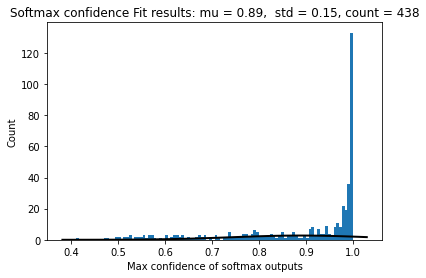

Tiny images plot


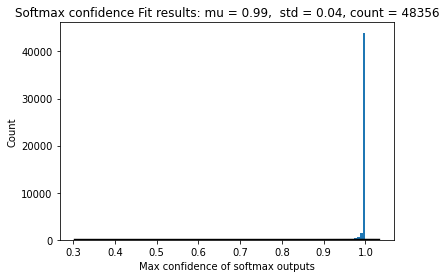

Cifat test plot


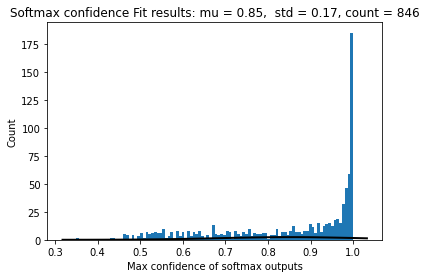

Cifar train plot


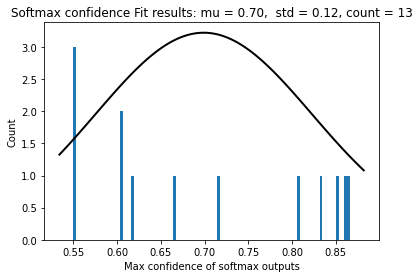

In [184]:
print("Ben recht plot")
plot_det_11thclass_conf_on_hard_part_hist(br_det_scores, br_preds)
print("Tiny images plot")
plot_det_11thclass_conf_on_hard_part_hist(ti_det_scores, ti_preds)
print("Cifat test plot")
plot_det_11thclass_conf_on_hard_part_hist(cifar_det_scores, cifar_preds)
print("Cifar train plot")
plot_det_11thclass_conf_on_hard_part_hist(cifar_train_det_scores, cifar_train_preds)

Ben recht plot


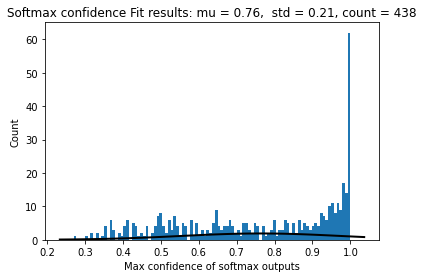

Tiny images plot


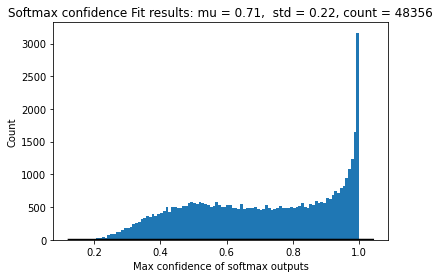

Cifat test plot


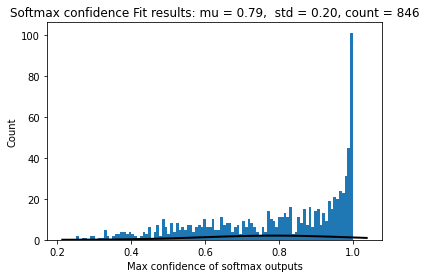

Cifar train plot


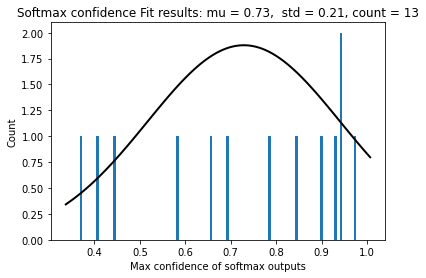

In [185]:
print("Ben recht plot")
plot_base_top_conf_on_hard_part_hist(br_base_scores, br_preds)
print("Tiny images plot")
plot_base_top_conf_on_hard_part_hist(ti_base_scores, ti_preds)
print("Cifat test plot")
plot_base_top_conf_on_hard_part_hist(cifar_base_scores, cifar_preds)
print("Cifar train plot")
plot_base_top_conf_on_hard_part_hist(cifar_train_base_scores, cifar_train_preds)

Ben recht plot


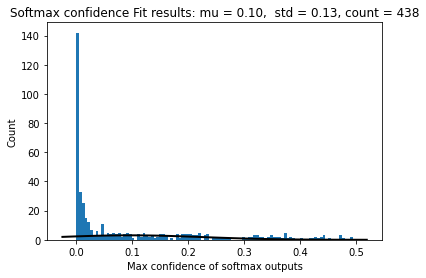

Tiny images plot


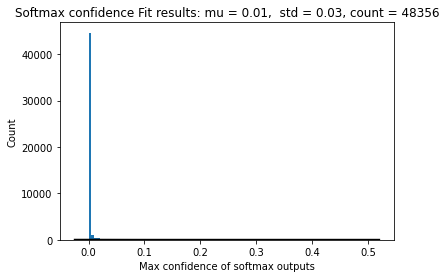

Cifat test plot


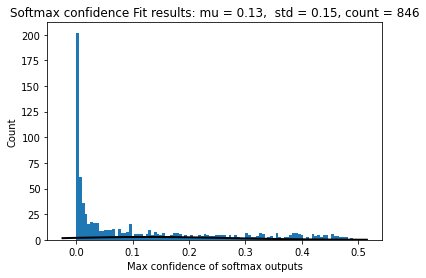

Cifar train plot


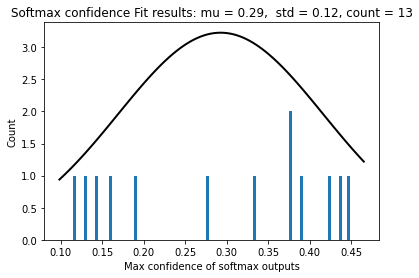

In [187]:
print("Ben recht plot")
plot_det_top_conf_on_hard_part_hist(br_det_scores, br_preds)
print("Tiny images plot")
plot_det_top_conf_on_hard_part_hist(ti_det_scores, ti_preds)
print("Cifat test plot")
plot_det_top_conf_on_hard_part_hist(cifar_det_scores, cifar_preds)
print("Cifar train plot")
plot_det_top_conf_on_hard_part_hist(cifar_train_det_scores, cifar_train_preds)